# Data Cleaning

The goal of this notebook/section will be to create a new dataset that will be easier to use during future parts of this project. This will inevitably lead to a more accurate regression model and a better, more interpretable result.

## Data and Package Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/train.csv')

There are 81 columns, 80 of them could be affecting our desired y variable ('SalePrice'). Using df.corr() and sns.heatmap() to find the quantitative variables that could affect and correlate to sale price to start cutting out variables that might not have a direct impact. This simplifies the Exploratory Data Analysis (EDA) process, data cleaning process, as well as resulting in a more accurate model that minimizes Root Mean Squared Error (RMSE). Among these current quantitative variables I plan to keep and use variables in the modeling process that have a correlation coefficient of 0.5 or higher. The variables that are not yet converted to numerics that are going to be used in the modeling process are going to be chosen by outside research to determine the categorical variables that have the highest impact on sale price. The three strongest variables that affect house price are condition of the home, concept of the home, and location [(Alfiyatin et al., 2017)](https://www.researchgate.net/profile/Wayan-Mahmudy-2/publication/320801620_Modeling_House_Price_Prediction_using_Regression_Analysis_and_Particle_Swarm_Optimization_Case_Study_Malang_East_Java_Indonesia/links/5a0fdbc4458515cc5aa6a91f/Modeling-House-Price-Prediction-using-Regression-Analysis-and-Particle-Swarm-Optimization-Case-Study-Malang-East-Java-Indonesia.pdf). The only other variables in the dataset that I am going to use other than the current numeric variables with a 0.5 correlation coefficient or above are 'Neighborhood' and 'MS SubClass'. The neighborhood variable captures location, while 'MS SubClass' captures the condition and concept of the home, thus, we can confidently infer that the variables that we are keeping in our dataset will have some effect on sale price.

We can also safely assume that total square footage of a home is going to be an impactful variable and feature that will affect sale price. Thus, I will be making a total home square footage variable comprised of the highest-impacting square footage variables and including it in my final dataframe. I am also going to create a new variable called 'home_age' which is going to be the age of the home at time of sale as it is likely that a variable like that will have a high impact on sale price as well.

In [3]:
df['home_sqft'] = df['Gr Liv Area'] + df['Garage Area'] + df['Total Bsmt SF'] # Creating a new SqFt variable that captures total living area sqft + garage sqft + basement sqft

In [4]:
df['home_age'] = df['Yr Sold'] - df['Year Built']
df = df[df['home_age'] >= 0] # removing any rows where home_age might be negative, as that isn't possible and indicates an error in the original data

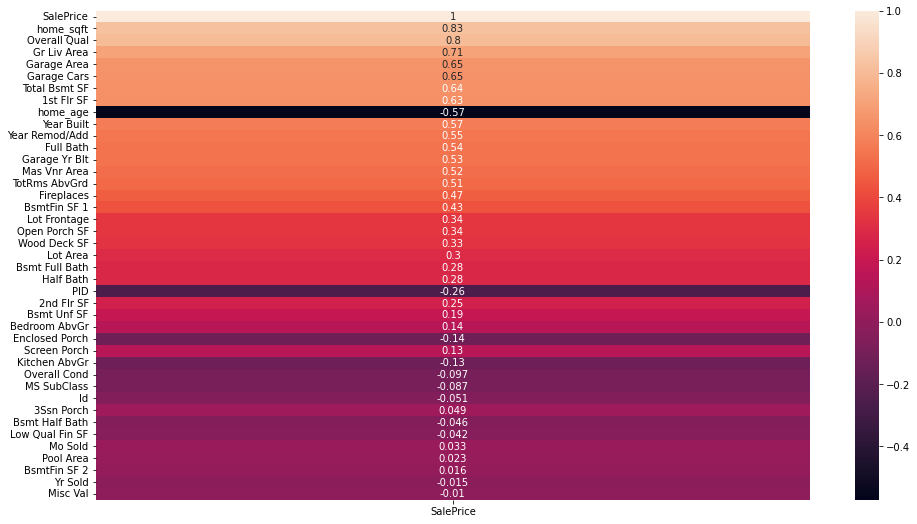

In [5]:
plt.figure(figsize=(16, 9))
sns.heatmap(df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False, key=abs), annot=True);

## Filtering Columns Out

In [6]:
df = df[[ # Filtering dataset by most important variables needed
    'Id', # ID of the home. Need this to complete the task.
    'Overall Qual', # Quality of the exterior of the home, rated 1-10.
    'home_sqft', # Sum SqFt of Garage, Living Areas, and Basement
    'Garage Cars', # Garage size by how many cars could fit (e.g. 2-car garage)
    'home_age',
    'Year Remod/Add', # Year remodelled. If not remodelled, same year as Year Built
    'Full Bath', # Number of full baths on the property
    'Mas Vnr Area', # Amount of masonry veneer - exterior decoration (e.g. brick, stone, etc.)
    'TotRms AbvGrd', # Total rooms above the basement.
    'Neighborhood',
    'MS SubClass', # Type of dwelling
    'SalePrice'
]]

## Cleaning Column Names

In [7]:
df = df.rename(columns={ # renaming columns to snake case
    'Id' : 'id',
    'Overall Qual' : 'home_quality',
    'Garage Cars' : 'garage_cars',
    'Year Remod/Add' : 'yr_remod',
    'Full Bath' : 'full_bath',
    'Mas Vnr Area' : 'masonry_veneer_area',
    'TotRms AbvGrd' : 'total_rooms_above_ground',
    'Neighborhood' : 'neighborhood',
    'MS SubClass' : 'home_type',
    'SalePrice' : 'sale_price'
})

## Managing Null Values

In [8]:
null_df = pd.DataFrame(df.isnull().sum(), columns=['Null Values']).sort_values(by='Null Values', ascending=False)
null_df[null_df['Null Values'] > 0]

,Null Values
masonry_veneer_area,22
home_sqft,2
garage_cars,1


These are all of the columns with null values. We will likely have to remove the 2 rows that have null values under 'home_sqft' as it is such an important variable. We could try to impute values into it depending on other variables but that would influence the relationship between home_sqft and sale_price as there are only 2000 variables. Based on the nature of the data, we can assume that nulls in masonry_veneer_area and garage_cars equate to zero, implying that the homes with nulls do not have a garage or any masonry veneer. We cannot make the same assumption of home_sqft.

In [9]:
df = df[~df['home_sqft'].isnull()] # Removing home_sqft's nulls from dataframe

In [10]:
df = df.fillna(0) # filling nulls in masonry_veneer_area and garage_cars with 0

## Changing home_type values

home_type is currently a numeric categorical variable. We need to change these numbers to be strings so that we can encode them later on.

In [11]:
dict_home_type = { # Creating a dictionary that correlates to the data dictionary and will replace numerics with string values in the 'home_type' / 'MS SubClass' column.
    20 : 'Newer 1 Story', 
    30 : 'Older 1 Story', 
    40 : '1 Story Finished Attic',
    45 : '1.5 Story Unfinished',
    50 : '1.5 Story Finished',
    60 : 'Newer 2 Story',
    70 : 'Older 2 Story',
    75 : '2.5 Story',
    80 : 'Split or Multi-Level',
    85 : 'Split Foyer',
    90 : 'Duplex',
    120 : '1 Story PUD',
    150 : '1.5 Story PUD',
    160 : '2 Story PUD',
    180 : 'PUD Multilevel',
    190 : '2 Family Conversion'
}

In [12]:
df.replace({'home_type' : dict_home_type}, inplace=True) # replacing numeric keys in series with string values in dict_home_type

## Export

In [13]:
df.to_csv('../data/train_clean.csv', index=False) # Clean data csv